# Contrast Optimization

This notebook attempts to show the effects on contrast as observations parameters are altered from a nominal state. We will start with the ERS observation of HIP 65426 as the nominal example (F444W + M335R), then explore different observational parameters to understand how this improves or worsens the performance.

This includes:

 * Integration Times (both science and reference)
 * Source brightness (both science and reference)
 * Spectral Type Matching

Overall, while this notebook demonstrates how each parameter affects detection limits, each section only explore parameter space along a single axis. One should of course attempt to optimize each element based on the science objective.

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import pynrc

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


## Source Definitions

Define science and reference source spectral information and fit model spectra to Vizier photometric data.

In [3]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# Science      source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sci = ('HIP 65426', 107.5, 14,  'A2V', 8840, 0.00, 4.00, 6.77, bp_k)

# References  source,     sptype, Teff, [Fe/H], log_g, mag, band
args_ref = ('HIP 68245', 'B2IV', None, None, None, 4.49, bp_k)

# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

In [4]:
# Fit spectrum to SED photometry
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sci
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = pynrc.source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[3,30])

# Final source spectrum (pysynphot)
sp_sci = src.sp_model
# sp_sci = src.sp0

SED best-fit params: [0.99576841]


In [5]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = args_ref
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = pynrc.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=True, wlim=[0.5,20])

# Final reference spectrum (pysynphot)
sp_ref = ref.sp_model
# sp_ref = ref.sp0

SED best-fit params: [1.02243165]


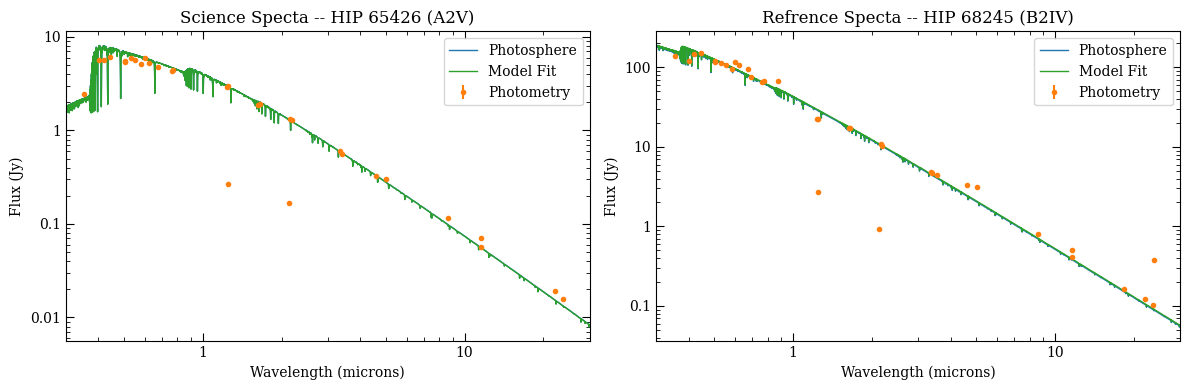

In [8]:
# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(12,4))
src.plot_SED(xr=[0.3,30], ax=axes[0])
ref.plot_SED(xr=[0.3,30], ax=axes[1])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

fig.tight_layout()

## Observation Setup

Initialize the high-contrast imaging class `pynrc.obs_hci` using the spectral objects and subarray configuration. The `obs_hci` object is a subclass of the more generalized `NIRCam` class. It implements settings and functions specific to high-contrast imaging observations for corongraphy and direct imaging.

In [9]:
# The initial call make take some time, as it will need to generate coefficients 
# to calculate PSF variations across wavelength, WFE drift, and mask location
filt, mask, pupil = ('F444W',  'MASK335R', 'CIRCLYOT')
wind_mode, subsize = ('WINDOW', 320)
fov_pix, oversample = (321, 2)

obs = pynrc.obs_hci(sp_sci, dist_sci, sp_ref=sp_ref, use_ap_info=False,
                    filter=filt, image_mask=mask, pupil_mask=pupil,
                    wind_mode=wind_mode, xpix=subsize, ypix=subsize, 
                    fov_pix=fov_pix, oversample=oversample, large_grid=True)

In [10]:
# Set default WFE drift values between Roll1, Roll2, and Ref
# These settings match well to the ERS observations

# WFE drift amount between rolls
obs.wfe_roll_drift = 2

# Drift amount between Roll 1 and Reference.
obs.wfe_ref_drift = 5

# Set pointing offsets to 0 under the assumption that SGD and PCA
# will remove the majority of these effects.
obs.gen_pointing_offsets(slew_std=0)

In [11]:
# Update both the science and reference observations
obs.update_detectors(read_mode='DEEP8', ngroup=15, nint=2)
obs.update_detectors_ref(read_mode='MEDIUM8', ngroup=4, nint=18)

In [12]:
# There will be two roll positions, so total science exposure time is doubled
print("Nominal Exposure Times")
print(f"  Sci Exp Time: {obs.Detector.time_exp:.2f} sec (x2 rolls)")
print(f"  Ref Exp Time: {obs.Detector_ref.time_exp:.2f} sec")

Nominal Exposure Times
  Sci Exp Time: 615.77 sec (x2 rolls)
  Ref Exp Time: 731.22 sec


## Performance Estimates

Next, we use the `calc_contrast` method to obtain the predicted sensitivity curves. The `calc_contrast` method returns a tuple of three arrays:
1. The radius in arcsec.
2. The n-sigma contrast.
3. The n-sigma magnitude sensitivity limit (vega mag).

### 0. Nominal Case

Compare nominal simulation to measured values from [_Carter et al. (2022)_](https://arxiv.org/abs/2208.14990)

In [13]:
# First, read in ERS contrast curves
import os
from astropy.io import ascii

ers_contrast_dir = 'ERS/ERS_HIP65426_CONTRAST_CURVES_V2/'
ers_contrast_file = f'{obs.filter}_ADI+RDI.txt'
ers_contrast_path = os.path.join(ers_contrast_dir, ers_contrast_file)

names = ['asec', 'contrast', 'contrast_uncal']
tbl_ers = ascii.read(ers_contrast_path, names=names)

# Clean up NaNs and infs
ind_nan = ~np.isfinite(tbl_ers['contrast'])
# Interpolate in log space
x, y = (tbl_ers['asec'][~ind_nan], np.log10(tbl_ers['contrast'][~ind_nan]))
tbl_ers['contrast'][ind_nan] = 10**np.interp(tbl_ers['asec'][ind_nan], x, y)

In [14]:
# Generate 5-sigma contrast curves
nsig = 5
roll_angle = 10

# For simulation purposes, turn off the corongraphic 
# mask features (ND squares and COM hodler)
contrast_nom = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, use_cmask=False)

In [37]:
def cont_to_sen(x):
    contrast = np.asarray(x)
    return -2.5*np.log10(contrast) + obs.star_flux('vegamag')

def sen_to_cont(x):
    sen_mag = np.asarray(x)
    return 10**((obs.star_flux('vegamag') - sen_mag) / 2.5)

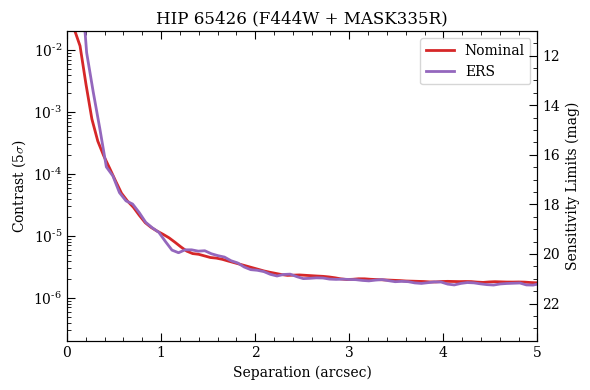

In [41]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.semilogy(contrast_nom[0], contrast_nom[1], color='C3', lw=2, label='Nominal')
ax.semilogy(tbl_ers['asec'], tbl_ers['contrast'], color='C4', lw=2, label='ERS')

ax.legend()

ax.set_xlim([0,5])
ax.set_ylim([2e-7, 2e-2])

ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel(f'Contrast ({nsig:.0f}$\sigma$)')

ax.set_title(f'{name_sci} ({obs.filter} + {obs.image_mask})')

# Create 2nd axis indicating sensitivity limits (mags)
ax2 = ax.twinx()
ax2.set_ylim(cont_to_sen(ax.get_ylim()))
ax2.set_ylabel('Sensitivity Limits (mag)')

fig.tight_layout()

### 1. Science Exposure Time

Plot contrast as a function of science exposure time. Assumes total reference time stays constant.

In [42]:
contrast_list = []
exptime_list = []
for nint in [1,4,6,8,12]:
    obs.update_detectors(read_mode='DEEP8', ngroup=15, nint=nint)
    res = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, use_cmask=False)
    contrast_list.append(res)

    exptime_tot = obs.Detector.time_exp
    exptime_list.append(exptime_tot)

    print(f"Sci Exp Time per Roll: {exptime_tot:.2f} sec")

# Return to original setting
obs.update_detectors(read_mode='DEEP8', ngroup=15, nint=2)
obs.update_detectors_ref(read_mode='MEDIUM8', ngroup=4, nint=18)

Sci Exp Time per Roll: 307.88 sec
Sci Exp Time per Roll: 1231.53 sec
Sci Exp Time per Roll: 1847.30 sec
Sci Exp Time per Roll: 2463.07 sec
Sci Exp Time per Roll: 3694.60 sec


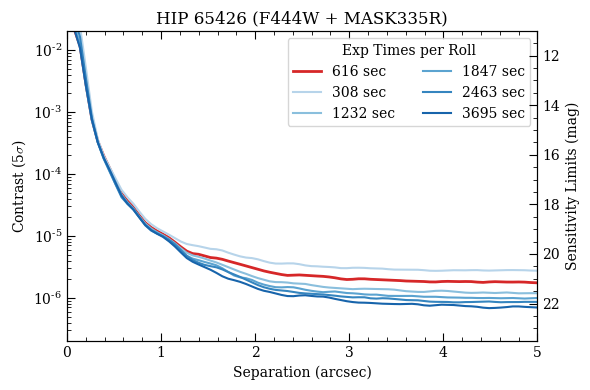

In [43]:
fig, ax = plt.subplots(1,1, figsize=(6,4))


lin_vals = np.linspace(0.3,0.8,len(contrast_list))
colors = plt.cm.Blues(lin_vals)

label = f'{obs.Detector.time_exp:.0f} sec'
ax.semilogy(contrast_nom[0], contrast_nom[1], color='C3', lw=2, label=label)

for i, contrast in enumerate(contrast_list):
    label = f'{exptime_list[i]:.0f} sec'
    ax.semilogy(contrast[0], contrast[1], color=colors[i], label=label)

ax.legend(title='Exp Times per Roll', ncol=2)

ax.set_xlim([0,5])
ax.set_ylim([2e-7, 2e-2])

ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel(f'Contrast ({nsig:.0f}$\sigma$)')

ax.set_title(f'{name_sci} ({obs.filter} + {obs.image_mask})')

# Create 2nd axis indicating sensitivity limits (mags)
ax2 = ax.twinx()
ax2.set_ylim(cont_to_sen(ax.get_ylim()))
ax2.set_ylabel('Sensitivity Limits (mag)')

fig.tight_layout()

**Conclusions:** No sensitivity improves below 1 arcsec as the increased time mostly goes towards improveing the background limit. Diminishing returns at larger exposure times.

### 2. Reference Exposure Time

Plot contrast as a function of reference exposure time. Assumes total science target time stays constant.

In [44]:
contrast_list = []
exptime_list = []
for nint in [5,9,30,60,90]:
    obs.update_detectors_ref(read_mode='MEDIUM8', ngroup=4, nint=nint)
    res = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, use_cmask=False)
    contrast_list.append(res)

    exptime_tot = obs.Detector_ref.time_exp
    exptime_list.append(exptime_tot)

    print(f"Ref Exp Time Total: {exptime_tot:.2f} sec")

# Return to original setting
obs.update_detectors(read_mode='DEEP8', ngroup=15, nint=2)
obs.update_detectors_ref(read_mode='MEDIUM8', ngroup=4, nint=18)

Ref Exp Time Total: 203.12 sec
Ref Exp Time Total: 365.61 sec
Ref Exp Time Total: 1218.71 sec
Ref Exp Time Total: 2437.41 sec
Ref Exp Time Total: 3656.12 sec


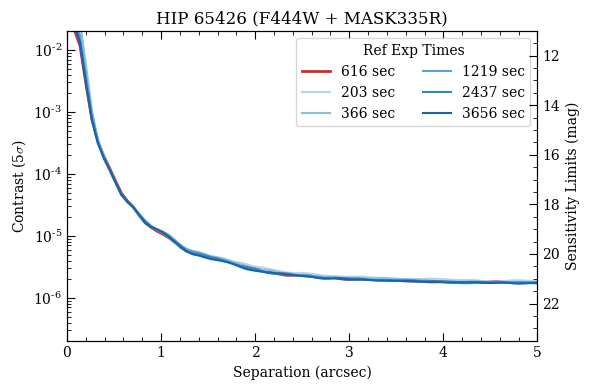

In [45]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

lin_vals = np.linspace(0.3,0.8,len(contrast_list))
colors = plt.cm.Blues(lin_vals)

label = f'{obs.Detector.time_exp:.0f} sec'
ax.semilogy(contrast_nom[0], contrast_nom[1], color='C3', lw=2, label=label)

for i, contrast in enumerate(contrast_list):
    label = f'{exptime_list[i]:.0f} sec'
    ax.semilogy(contrast[0], contrast[1], color=colors[i], label=label)

ax.legend(title='Ref Exp Times', ncol=2)

ax.set_xlim([0,5])
ax.set_ylim([2e-7, 2e-2])

ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel(f'Contrast ({nsig:.0f}$\sigma$)')

ax.set_title(f'{name_sci} ({obs.filter} + {obs.image_mask})')

# Create 2nd axis indicating sensitivity limits (mags)
ax2 = ax.twinx()
ax2.set_ylim(cont_to_sen(ax.get_ylim()))
ax2.set_ylabel('Sensitivity Limits (mag)')

fig.tight_layout()

**Conclusions:** In this scenario, changing the exposure time of the reference observations has virtually no effect on the final contrast. Instead, we are limited by total exposure time of the science target. This is because the reference star is 2.3 magnitudes brighter at K-Band, so it has an intrinsicly high SNR already relative to the science star. This highlights the importance of finding a nearby, bright reference star (of similar spectral type) for PSF subtraction.

### 3. Science Target Brightness

Compare performance for a variety of science target brightnesses.

In [46]:
kmag_list = [5,9,11,13,15,17,19]
contrast_list = []
for k in tqdm(kmag_list):
    obs.sp_sci = sp_sci.renorm(k, 'vegamag', bp_k)

    res = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, use_cmask=False)
    contrast_list.append(res)

# Return to original setting
obs.sp_sci = sp_sci

  0%|          | 0/7 [00:00<?, ?it/s]

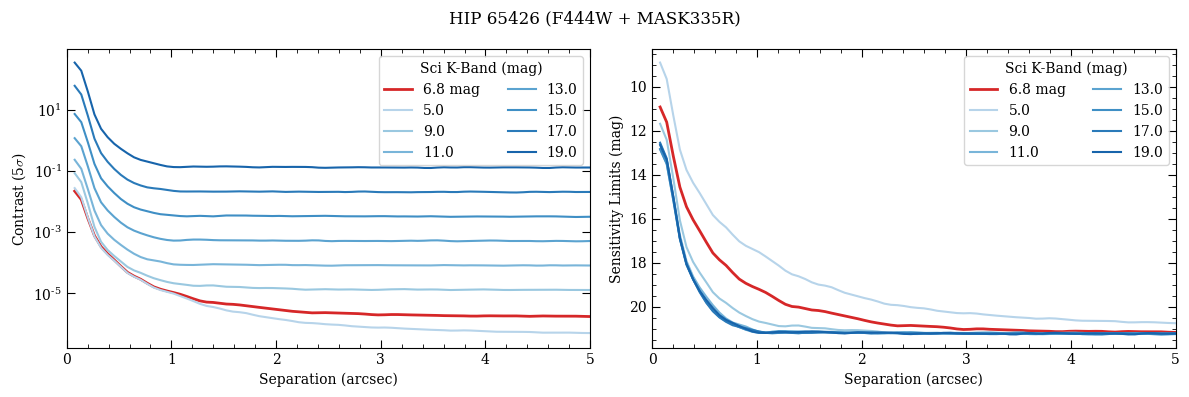

In [47]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

lin_vals = np.linspace(0.3,0.8,len(contrast_list))
colors = plt.cm.Blues(lin_vals)

ax = axes[0]

for ax in axes:
    # Plot nominal contrast curve
    if ax==axes[0]:
        plt_func = ax.semilogy
        yvals = contrast_nom[1]
    else: 
        plt_func = ax.plot
        yvals = contrast_nom[2]
    label = f'{mag_sci:.1f} mag'
    plt_func(contrast_nom[0], yvals, color='C3', lw=2, label=label)

    # Plot variations
    for i, contrast in enumerate(contrast_list):
        yvals = contrast[1] if ax==axes[0] else contrast[2]
        label = f'{kmag_list[i]:.1f}'
        plt_func(contrast[0], yvals, color=colors[i], label=label)

    ax.set_xlim([0,5])

    ax.set_xlabel('Separation (arcsec)')
    ylabel = f'Contrast ({nsig:.0f}$\sigma$)' if ax==axes[0] else 'Sensitivity Limits (mag)'
    ax.set_ylabel(ylabel)

    ax.legend(title='Sci K-Band (mag)', ncol=2)

axes[1].set_ylim(axes[1].get_ylim()[::-1])

fig.suptitle(f'{name_sci} ({obs.filter} + {obs.image_mask})')

fig.tight_layout()

**Conclusions:** Since we are modifying the instrinsic source brightness, the _contrast_ in the background limit changes significantly because the sensitivity stay constant. So, we must plot the sensitivity limits in a seaparate panel, showing us hitting the background limits at smaller IWA as the target becomes fainter. Background limits can of course be improved by further increasing exposure times for the science target.

### 4. Reference Target Brightness

Compare performance for a variety of reference target brightnesses.

In [48]:
kmag_list = [5,7, 9,11,13]
contrast_list = []
for k in tqdm(kmag_list):
    obs.sp_ref = sp_ref.renorm(k, 'vegamag', bp_k)

    res = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, use_cmask=False, opt_diff=True)
    contrast_list.append(res)

# Return to original setting
obs.sp_ref = sp_ref

  0%|          | 0/5 [00:00<?, ?it/s]

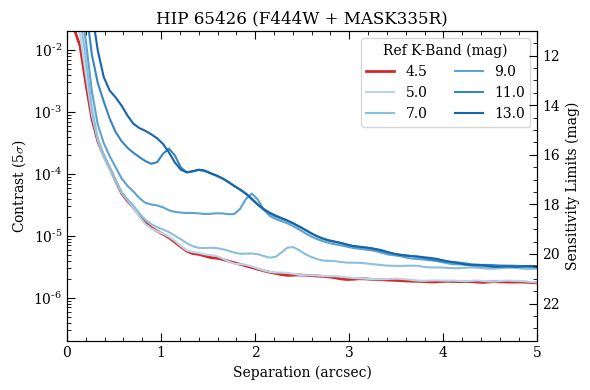

In [49]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

lin_vals = np.linspace(0.3,0.8,len(contrast_list))
colors = plt.cm.Blues(lin_vals)

label = f'{mag_ref:.1f}'
ax.semilogy(contrast_nom[0], contrast_nom[1], color='C3', lw=2, label=label)

for i, contrast in enumerate(contrast_list):
    label = f'{kmag_list[i]:.1f}'
    ax.semilogy(contrast[0], contrast[1], color=colors[i], label=label)

ax.legend(title='Ref K-Band (mag)', ncol=2)

ax.set_xlim([0,5])
ax.set_ylim([2e-7, 2e-2])

ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel(f'Contrast ({nsig:.0f}$\sigma$)')

ax.set_title(f'{name_sci} ({obs.filter} + {obs.image_mask})')

# Create 2nd axis indicating sensitivity limits (mags)
ax2 = ax.twinx()
ax2.set_ylim(cont_to_sen(ax.get_ylim()))
ax2.set_ylabel('Sensitivity Limits (mag)')

fig.tight_layout()

**Conclusions:** As expected, reducing the reference source brightness without accommodating for total photon collection time (to increase SNR) will significanly impact the final contrast. In order to match the nominal contrast, exposure times would need to be significantly increased. 

# 5. Spectral Type Mismatch

The science target is an A-Type star, which has a fairly smooth SED over the F444W banpass. We'll search over a range of spectral types to choose from to determine which to avoid.

In [61]:
sptypes = ['A0V', 'F0V', 'G0V', 'K0V', 'M0V', 'K0IV', 'G0III', 'K0III', 'M0III']
contrast_list = []

nrc_mag = obs.star_flux(fluxunit='vegamag', do_ref=True)
for spt in tqdm(sptypes):
    # New stellar spectrum normalized to same NIRCam magnitude
    obs.sp_ref = pynrc.stellar_spectrum(spt, nrc_mag, 'vegamag', obs.bandpass)

    res = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, use_cmask=False, opt_diff=True)
    contrast_list.append(res)

# Return to original setting
obs.sp_ref = sp_ref

  0%|          | 0/9 [00:00<?, ?it/s]

In [64]:
# Get sensitivity losses at 1.5" and sort
x, y = (contrast_nom[0], contrast_nom[1])
ind_med = (x>=1.0) & (x<=1.5)
mag_sen0 = -2.5*np.log10(np.mean(y[ind_med]))

dmag_arr = []
for i, contrast in enumerate(contrast_list):
    x, y = (contrast[0], contrast[1])
    ind_med = (x>=1.0) & (x<=1.5)
    mag_sen = -2.5*np.log10(np.mean(y[ind_med]))
    dmag = mag_sen0 - mag_sen
    dmag_arr.append(dmag)
dmag_arr = np.array(dmag_arr)

isort = np.argsort(dmag_arr)

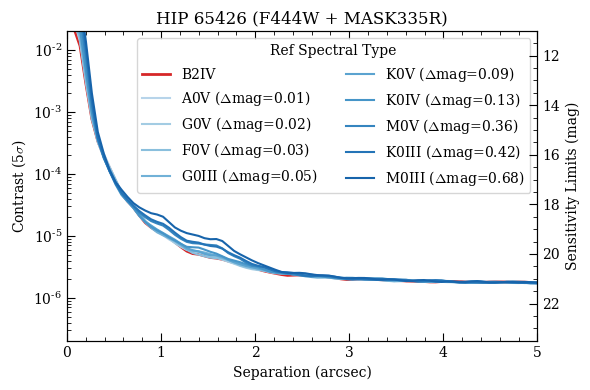

In [66]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

lin_vals = np.linspace(0.3,0.8,len(contrast_list))
colors = plt.cm.Blues(lin_vals)

label = f'{spt_ref}'
x, y = (contrast_nom[0], contrast_nom[1])
ax.semilogy(x, y, color='C3', lw=2, label=label)

for i in range(len(contrast_list)):
    ii = isort[i]

    contrast = contrast_list[ii]
    x, y = (contrast[0], contrast[1])

    dmag = dmag_arr[ii]
    label = f'{sptypes[ii]} ($\Delta$mag={dmag:.2f})'

    ax.semilogy(x, y, color=colors[i], label=label)

ax.legend(title='Ref Spectral Type', ncol=2)

ax.set_xlim([0,5])
ax.set_ylim([2e-7, 2e-2])

ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel(f'Contrast ({nsig:.0f}$\sigma$)')

ax.set_title(f'{name_sci} ({obs.filter} + {obs.image_mask})')

# Create 2nd axis indicating sensitivity limits (mags)
ax2 = ax.twinx()
ax2.set_ylim(cont_to_sen(ax.get_ylim()))
ax2.set_ylabel('Sensitivity Limits (mag)')

fig.tight_layout()

**Conclusions:** Probably best to avoid pairing A-Type observations with K- and M-Type stars, which shows much larger deviation within 1 to 1.5 arcsec.